In [19]:
import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sigpy as sp
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import os
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import pickle as pkl


In [3]:
def delete_zeros(kspace):
    ## function to remove extra zeros in knees
    # Compute sum-energy of lines
    # !!! This is because some lines are near-empty
    line_energy = np.sum(np.square(np.abs(kspace)),
                         axis=(0, 1))
    dead_lines  = np.where(line_energy < 1e-12)[0] # Sufficient for FP32
    # Always remove an even number of lines
    dead_lines_front = np.sum(dead_lines < 160)
    dead_lines_back  = np.sum(dead_lines > 160)
    if np.mod(dead_lines_front, 2):
        dead_lines = np.delete(dead_lines, 0)
    if np.mod(dead_lines_back, 2):
        dead_lines = np.delete(dead_lines, -1)
    # Remove dead lines completely
    k_image = np.delete(kspace, dead_lines, axis=-1)
    return k_image

def get_mvue(kspace, s_maps):
    # convert from k-space to mvue
    return np.sum(sp.ifft(kspace, axes=(-1, -2)) * np.conj(s_maps), axis=0) / np.sqrt(np.sum(np.square(np.abs(s_maps)), axis=0))

def img_mvue(x, s_maps):
    # convert from image to mvue
    coils = s_maps * x[None, ...] 
    mvue = np.sum(coils * np.conj(s_maps), axis=0) / np.square(np.linalg.norm(s_maps, axis=0))
    return mvue

def img_rss(x, s_maps):
    # convert from image to rss
    coils = s_maps * x[None, ...] 
    rss  = sp.rss(coils, axes=(0,))
    return rss

# Brain plots

## Map estimation

Uncomment the following code block if you need to estimate the maps. Change the input and output directory arguments accordingly.

In [ ]:
# !python estimate_maps --input-dir=datasets/brain_T2 --output-dir=datasets/brain_T2_maps

## Get ground-truth MVUE for Brains

fastMRI data is of shape 784x392 in the k-space domain, and is cropped to 384x384 in the image domain

In [26]:
slice_idx = 7
brain_shape = (384, 384)

# load kspace data and maps
with h5py.File( './datasets/brain_T2/file_brain_AXT2_200_2000019.h5') as f:
    brain_kspace = np.array( f['kspace'] )[slice_idx]
    
    
with h5py.File( './datasets/brain_T2_maps/file_brain_AXT2_200_2000019.h5') as f:
    brain_smaps = np.array( f['s_maps'] )[slice_idx]

# compute mvue
brain_mvue = get_mvue( brain_kspace, brain_smaps )

# crop in image domain
brain_mvue = sp.resize( brain_mvue, brain_shape )



## Load brain reconstruction

In [34]:
# this file name will have to be changed depending on your experiment
rec_file = f'outputs/2021-07-22/11-05-14/file_brain_AXT2_200_2000019.h5|langevin|slide_idx_{slice_idx}_R=4_outputs.pt'
brain_rec_ = torch.load( rec_file )['mvue']
brain_rec_ = brain_rec_.detach().cpu().numpy()
brain_rec = brain_rec_[0,0] + 1j * brain_rec_[0,1]



## Process reconstruction

Our reconstructions have shape 384x384. However, fastMRI data is of shape 768x392 in the k-space domain that is later cropped to 384x384 in the image domain. In order to match the resolutions, we need to pad in the k-space domain, do an IFFT, and then crop.

Typical end-to-end methods don't need to do this as they produce images of shape 768x392, and hence can crop to 384x384 directly in the image domain.

In [46]:
rec = sp.resize( brain_rec, (768, 384) ) # resize to fastMRI size in readout
rec = sp.fft( rec, axes=(-1,) ) # go to kspace in phase-encode
rec = sp.resize( rec, (768, brain_smaps.shape[-1]) ) # resize to fastMRI size in phase-encode
rec = sp.ifft( rec , axes=(-1,) ) # convert back to image domain

# get mvue and crop
brain_rec = img_mvue(rec, brain_smaps)
brain_rec = sp.resize( brain_rec, (384, 384) )

## Plot ground truth and reconstruction

Image must be flipped vertically since fastMRI has kspace upside down


Text(0.5, 1.0, 'Reconstructed MVUE')

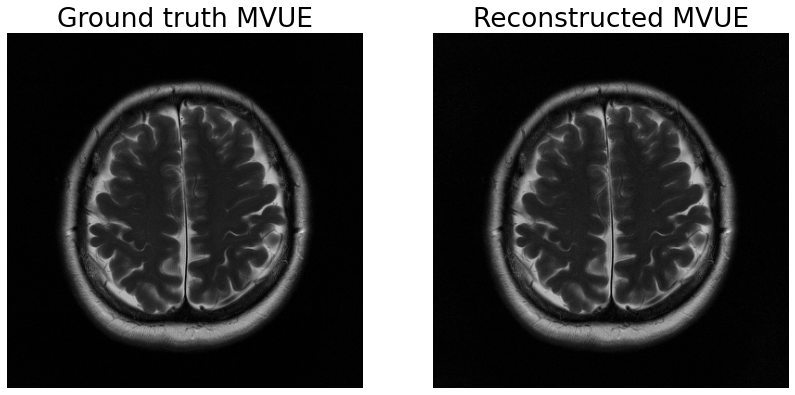

In [45]:
_, ax = plt.subplots( 1, 2, figsize=(14,7))

ax[0].imshow( np.abs(brain_mvue[::-1,]), cmap='gray')
ax[1].imshow( np.abs(brain_rec[::-1,]), cmap='gray')

ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title( 'Ground truth MVUE')
ax[1].set_title( 'Reconstructed MVUE')

In [47]:
plt.close()

# Knee plots

## load ground truth and estimate MVUE

In [67]:
slice_idx = 9
with h5py.File( './datasets/knees/file1000031.h5', 'r') as f:
    knees_kspace = np.array( f['kspace'] )[slice_idx]
with h5py.File( './datasets/knees_maps/file1000031.h5', 'r') as f:
    knees_smaps = np.array( f['s_maps'] )[slice_idx]
knees_mvue = get_mvue( knees_kspace, knees_smaps)
knees_mvue = sp.resize( knees_mvue, (320,320) )

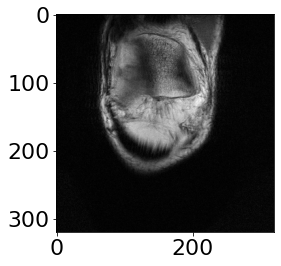

In [68]:
plt.imshow( np.abs(knees_mvue[::-1,::-1]) , cmap='gray')

## Load reconstructions

In [69]:
# this file name will have to be changed depending on your experiment
rec_file = f'outputs/2021-07-22/09-08-58/file1000031.h5|langevin|slide_idx_{slice_idx}_R=4_outputs.pt'
knees_rec_ = torch.load( rec_file )['mvue']
knees_rec_ = knees_rec_.detach().cpu().numpy()
knees_rec = knees_rec_[0,0] + 1j * knees_rec_[0,1]



## Process reconstructions

Our reconstructions have shape 320x320. However, fastMRI data is of shape 640x332 in the k-space domain that is later cropped to 320x320 in the image domain. In order to match the resolutions, we need to pad in the k-space domain, do an IFFT, and then crop.

Typical end-to-end methods don't need to do this as they produce images of shape 640x332, and hence can crop to 320x320 directly in the image domain.

In [70]:
rec = sp.resize( knees_rec, (knees_smaps.shape[-2], 320) ) # resize to fastMRI size in readout
rec = sp.fft( rec, axes=(-1,) ) # go to kspace in phase-encode
rec = sp.resize( rec, (knees_smaps.shape[-2], knees_smaps.shape[-1]) ) # resize to fastMRI size in phase-encode
rec = sp.ifft( rec , axes=(-1,) ) # convert back to image domain

# get mvue and crop
knees_rec = img_mvue(rec, knees_smaps)
knees_rec = sp.resize( knees_rec, (320, 320) )

Text(0.5, 1.0, 'Reconstructed MVUE')

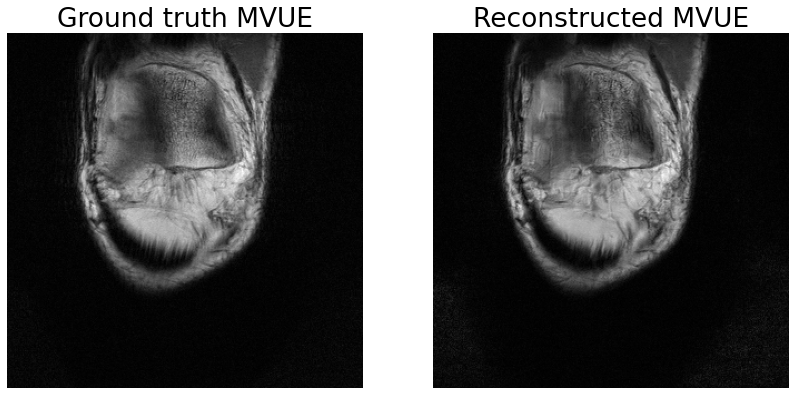

In [72]:
_, ax = plt.subplots( 1,2, figsize=(14,7))
ax[0].imshow( np.abs(knees_mvue[::-1,::-1]) , cmap='gray')
ax[1].imshow( np.abs(knees_rec[::-1,::-1]) , cmap='gray')
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Ground truth MVUE')
ax[1].set_title('Reconstructed MVUE')


### stanford ground truths

In [46]:
stanford_ground_truths = []
stanford_ground_truths_rss = []
for file in stanford_ground_truth:
    if '9.97' not in file:
        continue
    with h5py.File(file, 'r') as data:
        kspace, maps = np.array(data['kspace']), np.array(data['s_maps'])
        for idx, ksp in enumerate(kspace):
            map = maps[idx]
            mvue = get_mvue(ksp, map)
            stanford_ground_truths.append(mvue[::-1,:])
            rss = np.linalg.norm(sp.ifft(ksp, axes=(-1,-2)), axis=0)
            stanford_ground_truths_rss.append(rss[::-1,:])
            del mvue, rss
            
        del kspace, maps

### abs ground truths

In [ ]:
with h5py.File('./data2.h5', 'r') as f:
    ksp = np.array(f['ksp'])
    s_maps = np.array(f['maps'])

abdomen_ground_truths = []
abdomen_ground_truths_rss = []
# image_size = (192,320)
for i in range(34):
    gt_ksp = ksp[i]
    maps = s_maps[i]
#     # pad readout in image domain
#     x = sp.ifft(gt_ksp, axes=(-1,))
#     x = sp.resize(x, (x.shape[0], x.shape[1], image_size[1]))

#     # pad phase-encode in kspace domain
#     gt_ksp = sp.fft(x, axes=(-1,))
#     gt_ksp = sp.resize(gt_ksp, (gt_ksp.shape[0], image_size[0], image_size[1]))

#     # Crop extra lines and reduce FoV by half in readout
#     maps = sp.fft(maps, axes=(-1, -2)) # These are now maps in k-space
#     maps = sp.ifft(maps, axes=(-1,))
#     maps = sp.resize(maps, (
#     maps.shape[0], maps.shape[1], image_size[1]))
#     maps = sp.fft(maps, axes=(-1,))

#     # pad phase-encode in kspace domain
#     maps = sp.resize(maps, (maps.shape[0], image_size[0],
#     image_size[1]))
#     maps = sp.ifft(maps, axes=(-1, -2)) # Finally convert back to image domain


    # find mvue image
    mvue = get_mvue(gt_ksp, maps)[:,::-1]
    abdomen_ground_truths.append(mvue)
    del mvue
del ksp, s_maps


### stanford reconstructions

In [ ]:
stanford_reconstructions = {}
stanford_reconstructions_paths = {}

for R in [5.62, 7.63, 9.97, 12.66, 15.53]:
    stanford_reconstructions[R] = []
    stanford_reconstructions_paths[R] = []

    for file in stanford_ground_truth:
        base = os.path.basename(file)
        temp = base.split('-')
        prefix = '-'.join(temp[:4])
        suffix = '-'.join(temp[-1:])
        newname = prefix + f'-R{R}-' + suffix
#             try:
#                 rec_folder = stanford_rec_folders[R][0]
#                 rec_name = os.path.join(rec_folder, base + f'_outputs.pt')
#                 states = torch.load(rec_name)
#                 rec_ = states['mvue'].cpu().numpy()
#                 rec = rec_[0,0] + 1j * rec_[0,1]
#                 stanford_reconstructions[R].append(rec)

#             except FileNotFoundError:
#                 print(f'{rec_name} not found')
        for i in range(8):
            try:
                rec_folder = stanford_rec_folders['poisson'][R][0]
                rec_name = os.path.join(rec_folder, newname + f'|langevin|slide_idx_{i}_R={R}_outputs.pt')
                states = torch.load(rec_name)
                rec_ = states['mvue'].cpu().numpy()
                rec = rec_[0,0] + 1j * rec_[0,1]
                rec = rec[::-1,:]
    #                 rec_name = os.path.join(rec_folder, base + f'_R={R}_2299.jpg')
    #                 rec = np.array(Image.open(rec_name).convert('LA'))[:,:,0]
                stanford_reconstructions[R].append(rec)
                stanford_reconstructions_paths[R].append(rec_name)
                del states, rec_, rec
            except FileNotFoundError:
                print(f'{rec_name} not found')
# Stanford-Knee-Axial-P8-R15.53-Selected.h5|langevin|slide_idx_7_R=15.53_outputs.pt

### stanford crime reconstructions

In [ ]:
stanford_crime_reconstructions = {}

for pattern in ['equispaced-vertical']:
    stanford_crime_reconstructions[pattern] = {}
    for R in [2,4,8,12]:
        stanford_crime_reconstructions[pattern][R] = []

    for i in range(1,19):
        f = f'ge{i}.h5'
#         print('{}-'.format(i),f)
        for R in [2, 4, 8, 12]:

            # rec = torch.load('./outputs/2021-05-20/15-37-49/ge13.h5|langevin|slide_idx_13_R=4_outputs.pt')

            rec = torch.load(f'{stanford_crime_rec_folders[pattern][R][0]}{f}|langevin|slide_idx_{i}_R={R}_outputs.pt')
            rec_mvue_ = rec['mvue']
            rec_mvue = rec_mvue_[0,0] + 1j * rec_mvue_[0,1]
            rec_mvue = rec_mvue.cpu().numpy()[::-1,::-1]
            stanford_crime_reconstructions[pattern][R].append(rec_mvue)
            del rec, rec_mvue, rec_mvue_


### abs reconstructions

In [ ]:
abdomen_reconstructions = {}

for pattern in ['equispaced-horizontal', 'random-horizontal']:
    abdomen_reconstructions[pattern] = {}
    for R in [2,4,8,12]:
        abdomen_reconstructions[pattern][R] = []
        folder = abdomen_rec_folders[pattern][R][0]
        for i in range(34):
            filename = os.path.join(folder, f'{i}|langevin|slide_idx_{i+1}_R={R}_outputs.pt')
            states = torch.load(filename)
            rec_ = states['mvue'].cpu().numpy()
            rec = rec_[0,0] + 1j * rec_[0,1]
            ksp = sp.fft(rec, axes=(-1,-2))
            ksp = sp.resize(ksp, (158, 320))
            rec = sp.ifft(ksp, axes=(-1,-2))
            rec = rec[:, ::-1]
            abdomen_reconstructions[pattern][R].append(rec)
            del states, rec_, rec
